# PROJECT-3. Анализ воронки
### Пархоменко Евгения Александровна
#### DARP 1014

### ОПИСАНТЕ ГИПОТЕЗЫ
Проверим три предположения:
- Должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?
- Верно ли, что повторное прохождение обучения положительно влияет на оплату?
- Если пользователь сначала выбирает уровень сложности, будет ли он потом проходить обучение?

Проверку будем производить на основе данных пользователей, которые зарегистрировались в 2018 году.

### ЦЕЛЬ
Исследовать поведение пользователей в обновлённом приложении.

### ЗАДАЧИ
В рамках проверки гипотез вам необходимо решить три задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

### КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)

1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

### Ход проверки

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


Получаем данные

In [2]:
event = pd.read_csv("C:/IDE/Dataset/7_4_Events.csv")
events_df = event.copy()
# переименум колонку  id  в  event_id
events_df = events_df.rename(columns={'id':'event_id'})

In [3]:
purchase  = pd.read_csv("C:/IDE/Dataset/purchase.csv")
purchase_df = purchase.copy()
# переименум колонку  id  в  purchase_id и event_datetime в start_time
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

По условию, все задания необходимо выполнять с использованием данных пользователей, зарегистрировавшихся в 2018 году.

In [4]:
# Определяем дату начала и конца нашей выборки (2018)
mask_even_1 = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] < '2019-01-01')

# Выбираем только зарегестрированых пользователей
mask_even_2 = events_df['event_type'] == 'registration'

# Cоздаем список пользователей зарегистировавшихся в 2018 году
users_even_2018 = events_df[mask_even_1 & mask_even_2]['user_id'].to_list()

# Применяем наш список зарегистрировавшихся в 2018 году пользователей к таблице,
# тем самым убирая из нее пользователей, которые не попали в этот список
events_df = events_df[events_df['user_id'].isin(users_even_2018)]

# Смотрим результат (из 252334 пользователей осталось 66959)
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_id        66959 non-null  int64  
 1   event_type      66959 non-null  object 
 2   selected_level  8342 non-null   object 
 3   start_time      66959 non-null  object 
 4   tutorial_id     32954 non-null  float64
 5   user_id         66959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.6+ MB


Применяем наш список зарегистрировавшихся в 2018 году пользователей к таблице, тем самым убирая из нее пользователей, которые не попали в этот список

In [5]:
purchase_df = purchase_df[purchase_df['user_id'].isin(users_even_2018)]
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   purchase_id  1600 non-null   int64 
 1   user_id      1600 non-null   int64 
 2   start_time   1600 non-null   object
 3   amount       1600 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.5+ KB


Производим преобразование типов

In [6]:
events_df['start_time'] = pd.to_datetime(events_df['start_time'])
purchase_df['start_time'] = pd.to_datetime(purchase_df['start_time'])

Добавим в датафрейм purchase_df столбец event_type, который будет содержать одно значение purchase. Это нужно, чтобы в объединённом датафрейме однозначно выделить события оплаты.

In [7]:
purchase_df['event_type'] = 'purchase'

Сделаем объединенный датафрейм из событий и оплат

In [8]:
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')
total_events_df.head(3)

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN


## Проверяем гипотезу № 1
- Должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

Создадим сводную таблицу по минимальному времени начала этапа для подсчета дальнейше разницы

In [9]:
pivot_df = total_events_df.pivot_table(values='start_time', index='user_id', columns='event_type', aggfunc='min') 

Посчитаем время между этапами

In [10]:
# время от регистрации до начала обучения
pivot_df['delta_tutorial_start'] = (pivot_df['tutorial_start'] - pivot_df['registration'])/ pd.Timedelta('1 hour') 
# время от регистрации до конца обучения
pivot_df['delta_tutorial_finish'] = (pivot_df['tutorial_finish'] - pivot_df['registration'])/ pd.Timedelta('1 hour') 
# время на всю последовательность
pivot_df['delta_all_time'] = (pivot_df['purchase'] - pivot_df['registration'])/ pd.Timedelta('1 hour') 
# время от выбоара сложности до окончания обучения
pivot_df['delta_level_choice'] = (pivot_df['level_choice'] - pivot_df['tutorial_finish'])/ pd.Timedelta('1 hour') 
# время от выбора сложности до покупки
pivot_df['delta_pack_choice'] = (pivot_df['pack_choice'] - pivot_df['level_choice'])/ pd.Timedelta('1 hour') 
# время на оплату
pivot_df['delta_purchase'] = (pivot_df['purchase'] - pivot_df['pack_choice'])/ pd.Timedelta('1 hour') 
pivot_df = pivot_df.reset_index()

Создадим списки пользователей:
- список всех пользователей (all_users);
- пользователи, которые начинали обчение (users_with_started_tutorial);
- пользовватели, которые не начинали обучение (not_start_tutorial);
- пользователи, которые завершили обучение (tutorial_finished_users).

In [11]:
all_users = set(total_events_df['user_id'].unique())
users_with_started_tutorial = set(total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'])
not_start_tutorial = set(all_users.difference(users_with_started_tutorial))
tutorial_finished_users = set(total_events_df[total_events_df["event_type"] == "tutorial_finish"]['user_id'])
users_not_finished_tutorial = set(users_with_started_tutorial.difference(tutorial_finished_users))

Создадим новый признак 'group', где разделим  всех пользователей на группы

In [12]:
def get_tutorial_status (user_id):
    if user_id in not_start_tutorial:
        return 'not_started'
    elif user_id in tutorial_finished_users:
        return 'finished'
    elif user_id in users_not_finished_tutorial:
        return 'not_finished' 
    
pivot_df['group'] = pivot_df['user_id'].apply(get_tutorial_status)

Расчитаем среднее время, затраченное различными группами пользователей, на прохождение игры (от этапа регистрации, до совершения покупки)

In [13]:
user_group = pivot_df.groupby(['group'], as_index=False)['delta_all_time'].mean().round(2)

Строим график

In [14]:
fig = px.bar(
    data_frame=user_group,
    x="group",
    y="delta_all_time",
    text = 'delta_all_time',
    orientation='v',
    height=500,
    width=1000,
    title='Влияние прохождения этапа обучения на скорость прохождения игры'
)
fig.show()

### ВЫВОД: 
#### успешное обучение приближает пользователя к покупке.
- быстрее всего покупку совершают пользователи, которые успешно завершили обучение (они переходят к покупке примерно на 5 часов быстрее, чем пользователи, которые начали, но не завершили обучение, и на 8,6 часов быстрее, чем пользователи, которые не начинали обучение);
- у пользователей, которые начали обучение, но не завершили его, тратят больше времени до совершения покупки (около 5 часов, по сравнению с пользователями, которые завершили обучение). Но все же они совешают покупку быстрее, чем пользователи, которые не начинали обучение (разница во времени 3,5 часа);
- дольше всего к этапу покупки подходят пользователи, кторые не начинали обучение.


## Проверяем гипотезу № 2
- Верно ли, что повторное прохождение обучения положительно влияет на оплату (существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.)?



Формируем DataFrame по количеству начинаний обучений 

In [15]:
count_start = total_events_df[total_events_df['event_type'] == 'tutorial_start'].groupby(by='user_id', as_index = False)['event_type'].count()
count_start = count_start.rename(columns={'event_type':'count_start'})

Формируем DataFrame по количеству завершений обучений 

In [16]:
count_finish = total_events_df[total_events_df['event_type'] == 'tutorial_finish'].groupby(by='user_id', as_index = False)['event_type'].count()
count_finish = count_finish.rename(columns={'event_type':'count_finish'})

Формируем DataFrame по количеству оплат

In [17]:
clients_df = total_events_df[total_events_df['event_type'] == 'purchase'].groupby(by='user_id', as_index = False)['amount'].count()


Объеденяем DataFrame count_start и count_finish в промежуточный DataFrame merged_1

In [18]:
merged_1 = count_start.merge(
    count_finish, 
    on='user_id',
    how='left'
)

Объеденяем DataFrame merged_1 и clients_df в итоговый DataFrame conversion_df


In [19]:
conversion_df = merged_1.merge(
    clients_df, 
    on='user_id',
    how='left'
)
conversion_df['count_finish'] = pd.to_numeric(conversion_df['count_finish'], errors='coerce').fillna(0).astype('int64')

Строим графики:
- зависимость оплат от попыток прохождения обучения
- зависимость оплат от количества окончаний обучения

C:\Users\Евгения\AppData\Local\Temp\ipykernel_10852\1082318394.py:22: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



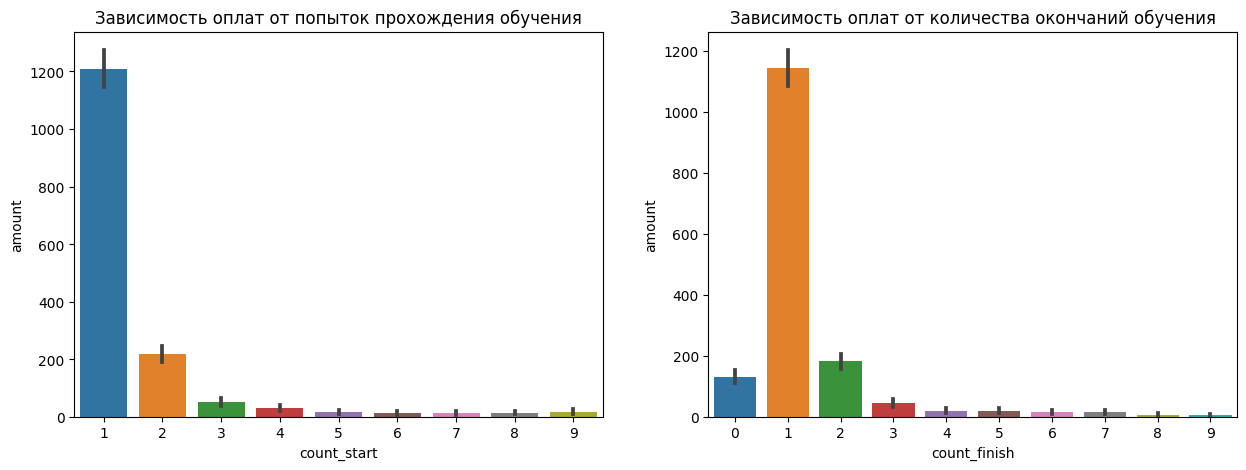

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# gthdsq uhfabr
barplot1 = sns.barplot(
    data = conversion_df,
    x = 'count_start',
    y = 'amount',
    estimator = 'sum',
    ax = axes[0]
)
axes[0].set_title('Зависимость оплат от попыток прохождения обучения')

barplot2 = sns.barplot(
    data = conversion_df,
    x = 'count_finish',
    y = 'amount',
    estimator = 'sum',
    ax = axes[1]
)
axes[1].set_title('Зависимость оплат от количества окончаний обучения')


fig.show()

Формируем DataFrame по количеству "ничинаний" обучений

In [21]:
count_start = conversion_df.groupby('count_start', as_index = False)['user_id','amount'].count()
count_start = count_start.rename(columns={'count_start':'count_attempt','amount':'amount_start','user_id':'user_id_start'})

C:\Users\Евгения\AppData\Local\Temp\ipykernel_10852\345864991.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Формируем DataFrame по количеству окончаний обучений

In [22]:
count_finish = conversion_df.groupby('count_finish', as_index = False)['user_id','amount'].count()
count_finish = count_finish.rename(columns={'count_finish':'count_attempt', 'amount':'amount_finish','user_id':'user_id_finish'})

C:\Users\Евгения\AppData\Local\Temp\ipykernel_10852\454565653.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Объеденяем DataFrame по количеству "ничинаний" обучений и количеству окончаний обучений

In [23]:
conversion_df_2 = count_finish.merge(
    count_start, 
    on='count_attempt',
    how='left'
)
conversion_df_2['amount_start'] = conversion_df_2['amount_start'].fillna(0).astype('int64')

Расчитываем конверсию:
- для группы по количеству "начинаний" обучений (добавляем в DF признак conversion_start);
- для группы по количеству завершений обучений (добавляем в DF признак conversion_finish)

In [24]:
conversion_df_2['conversion_finish'] = (conversion_df_2['amount_finish']/conversion_df_2['user_id_finish']*100).round(2)
conversion_df_2['conversion_start'] = (conversion_df_2['amount_start']/conversion_df_2['user_id_start']*100).round(2)
conversion_df_2

,count_attempt,user_id_finish,amount_finish,user_id_start,amount_start,conversion_finish,conversion_start
0,0,1608,131,NaN,0,8.15,NaN
1,1,8015,1143,9103.0,1207,14.26,13.26
2,2,1321,182,1589.0,218,13.78,13.72
3,3,345,44,427.0,51,12.75,11.94
4,4,178,19,221.0,30,10.67,13.57
5,5,117,19,109.0,16,16.24,14.68
6,6,101,15,116.0,14,14.85,12.07
7,7,97,15,94.0,12,15.46,12.77
8,8,54,6,86.0,13,11.11,15.12
9,9,22,4,113.0,17,18.18,15.04


Строим график сравнения конверсии по группам пользователей в зависимости от "ничинаний" и завершений обучений

In [25]:
fig = px.line(
    data_frame=conversion_df_2, 
    x='count_attempt', 
    y=['conversion_start', 'conversion_finish'], 
    height=500, 
    width=1000, 
    title='Сравнение конверсии по группам пользователей' 
)
fig.show()

Считаем среднюю конверсию по группам

In [26]:
print(conversion_df_2['conversion_start'].mean().round(2))
print(conversion_df_2['conversion_finish'].mean().round(2))

13.57
13.54


### ВЫВОД: 
#### успешное обучение положительно влияет на оплату, не зависимо от попыток прохождения обучения;
#### факт окончания или начала обучения значительно повышает вероятность оплаты
- самая большая группа пользоватей, это те, кто начал или завершил обечение с первой попытки. Но конверсия в этой группе практически не отличается от групп с количеством попыток от 2-х до 9-ти.
- около 8,15% пользователей, не закончивших обучение совершают покупку, в то время как средняя конвесия совершения покупки у пользователей начинавших, либо заканчивавших обучение на 60% выше(13.57 и 13.54%);
- средняя конверсия в двух этих группах практически одинакова (13.57 и 13.54%). Но, если исключить из наблюдений пользователей, которые начали, но не закончили обучение, средняя конверсия совершения покупки выше в группе пользователей, которые окончили обучение.

## Проверяем гипотезу № 3
- Если пользователь сначала выбирает уровень сложности, будет ли он потом проходить обучение?
### ЗАДАЧA

Определить, насколько прозрачен процесс взаимодействия с игрой.

### КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)

Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

Формируем DataFrame, выбрав всех пользователей, для которых есть событие начала обучения (tutorial_start)

Переименовываем столбцы

Удаляем столбцы, которые нам не понабятся  в расчетах ('event_id', 'event_type','selected_level', 'tutorial_id', 'purchase_id', 'amount')

In [27]:
tutorial_start_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']
tutorial_start_df = tutorial_start_df.rename(columns={'start_time':'tutorial_start_time'})
tutorial_start_df = tutorial_start_df.drop(['event_id', 'event_type','selected_level', 'tutorial_id', 'purchase_id', 'amount'], axis=1)

Формируем DataFrame, выбрав всех пользователей, для которых есть событие начала обучения (level_choice)

Переименовываем столбцы

Удаляем столбцы, которые нам не понабятся  в расчетах ('event_id', 'event_type','selected_level', 'tutorial_id', 'purchase_id', 'amount')

In [28]:
level_choice_df = total_events_df[total_events_df['event_type'] == 'level_choice']
level_choice_df = level_choice_df.rename(columns={'start_time':'level_choice_start_time'})
level_choice_df = level_choice_df.drop(['event_id', 'event_type','selected_level', 'tutorial_id', 'purchase_id', 'amount'], axis=1)

Объеденяем DF tutorial_start_df и level_choice_df

In [29]:
tutorial_start_level_choise_df = tutorial_start_df.merge(level_choice_df, on='user_id', how='inner')
tutorial_start_level_choise_df

,tutorial_start_time,user_id,level_choice_start_time
0,2018-01-01 15:00:51,27835,2018-01-01 20:37:22
1,2018-01-01 19:11:36,27839,2018-01-01 22:37:50
2,2018-01-02 02:07:07,27840,2018-01-02 05:18:42
3,2018-01-02 03:03:44,27845,2018-01-02 06:19:18
4,2018-01-02 07:08:00,27845,2018-01-02 06:19:18
...,...,...,...
12681,2018-12-31 07:14:38,47732,2018-12-31 09:59:00
12682,2018-12-31 10:21:11,47747,2018-12-31 12:24:40
12683,2018-12-31 20:54:56,47753,2018-12-31 22:36:19
12684,2019-01-01 00:08:14,47755,2019-01-01 05:04:52


Находим разницу между событиями начала обучения и выбором уровня сложности:
- если разница отрицательная, зачит пользователь сначала приступил к обучению, а затем выбрал уровень сложности;
- если разница положительная, значит пользователь сначала выбрал уровень сложности, а затем вернулся к обучению

In [30]:
tutorial_start_level_choise_df['time_delta'] = tutorial_start_level_choise_df['tutorial_start_time'] - tutorial_start_level_choise_df['level_choice_start_time']

tutorial_start_level_choise_df

,tutorial_start_time,user_id,level_choice_start_time,time_delta
0,2018-01-01 15:00:51,27835,2018-01-01 20:37:22,-1 days +18:23:29
1,2018-01-01 19:11:36,27839,2018-01-01 22:37:50,-1 days +20:33:46
2,2018-01-02 02:07:07,27840,2018-01-02 05:18:42,-1 days +20:48:25
3,2018-01-02 03:03:44,27845,2018-01-02 06:19:18,-1 days +20:44:26
4,2018-01-02 07:08:00,27845,2018-01-02 06:19:18,0 days 00:48:42
...,...,...,...,...
12681,2018-12-31 07:14:38,47732,2018-12-31 09:59:00,-1 days +21:15:38
12682,2018-12-31 10:21:11,47747,2018-12-31 12:24:40,-1 days +21:56:31
12683,2018-12-31 20:54:56,47753,2018-12-31 22:36:19,-1 days +22:18:37
12684,2019-01-01 00:08:14,47755,2019-01-01 05:04:52,-1 days +19:03:22


Находим пользователей, прошедших обучение после выбора уровня сложности

In [31]:
users_tutorial_after_level_choice = tutorial_start_level_choise_df[tutorial_start_level_choise_df['time_delta']>'1 seconds']['user_id'].nunique()
users_tutorial_after_level_choice 

1386

Находим пользователей, прошедших обучение до выбора уровня сложности

In [32]:
users_tutorial_before_level_choice = tutorial_start_level_choise_df[ tutorial_start_level_choise_df\
    ['time_delta']<pd.Timedelta(0)]['user_id'].nunique()
users_tutorial_before_level_choice 

8244

Находим процент пользователей, вернувшихся к обучению, после выбора уровня сложности

In [33]:
persent_users_after_level = users_tutorial_after_level_choice/users_tutorial_before_level_choice*100
persent_users_after_level

16.812227074235807

Сторим круговую диаграмму

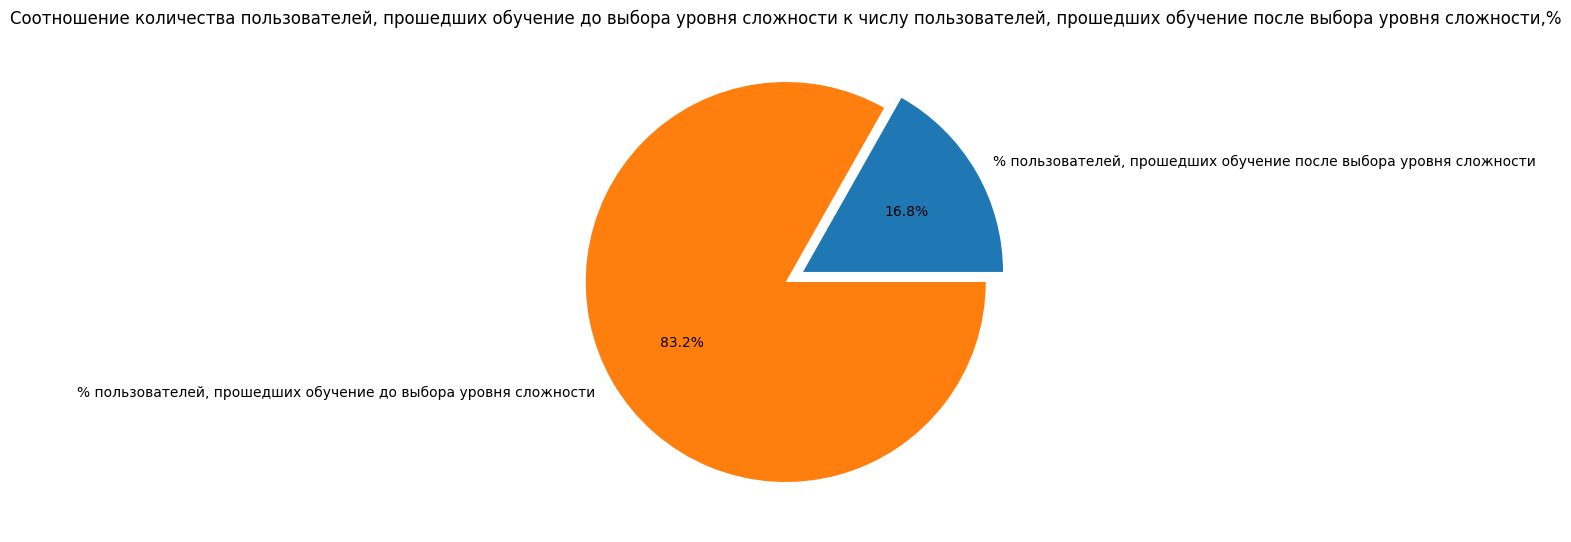

In [34]:
a = [persent_users_after_level,100-persent_users_after_level]
labels = ['% пользователей, прошедших обучение после выбора уровня сложности', '% пользователей, прошедших обучение до выбора уровня сложности']
fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
        a, 
        labels = labels, 
        autopct='%1.1f%%', 
        explode=[0.1,0])
axes.set_title("Соотношение количества пользователей, прошедших обучение до выбора уровня сложности к числу пользователей, прошедших обучение после выбора уровня сложности,%")
plt.show()

### ВЫВОД: 
#### после выбора уровня сложности к обучению возвращается 16,8 % пользователей.
- это может говорить о том, что процесс взаимодействия с игрой не совсем прозрачен и требует доработки.